# Grayscale Image Segmentation And Validation

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import scipy.ndimage
import skimage.filters
import sklearn.metrics

plt.ion()

# LOADING AND VISUALIZING DATA

/home/pranathi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/home/pranathi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'groundtruth image segmentation')

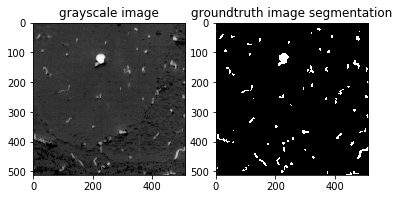

In [3]:
grayscale = scipy.misc.imread("grayscale.png")
grayscale = 255 - grayscale
groundtruth = scipy.misc.imread("groundtruth.png")

plt.subplot(1, 2, 1)
plt.imshow(grayscale, cmap='gray')
plt.title("grayscale image")
plt.subplot(1, 2, 2)
plt.imshow(groundtruth, cmap='gray')
plt.title("groundtruth image segmentation")

IMAGE PIXEL INTENSITY HISTOGRAM

Text(0.5, 1.0, 'Grayscale image histogram')

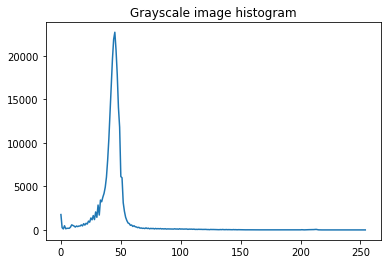

In [4]:
counts, vals = np.histogram(grayscale, bins=range(2 ** 8))

plt.plot(range(0, (2 ** 8) - 1), counts)
plt.title("Grayscale image histogram")

# PRE-PROCESSING

Text(0.5, 1.0, 'median filtered image')

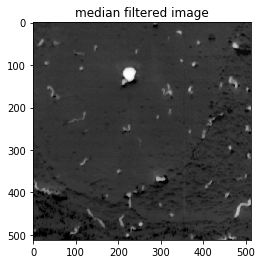

In [5]:
median_filtered = scipy.ndimage.median_filter(grayscale, size=3)
plt.imshow(median_filtered, cmap='gray')
plt.title("median filtered image")

# SEGMENTATION/THRESHOLDING USING SKIMAGE 

skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_yen


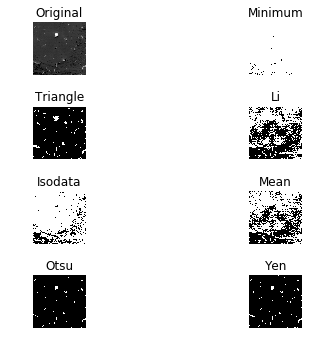

In [6]:
result = skimage.filters.thresholding.try_all_threshold(median_filtered)

1. Otsu threshold - The algorithm assumes that the image contains two classes of pixels following bi-modal histogram (foreground pixels and background pixels), it then calculates the optimum threshold separating the two classes so that their combined spread (intra-class variance) is minimal, or equivalently (because the sum of pairwise squared distances is constant), so that their inter-class variance is maximal

In [7]:
def segment_im(image, method):
    """
    Return a binary image with 0's and 255's after using threshold calculated by using the given "method"
    
    :param image grayscale one channeled image to binarize 
    :param method can be any one of skimage.filters.thresholding methods i.e threshold_adaptive, 
     threshold_mean, threshold_sauvola, threshold_isodata, threshold_minimum, threshold_triangle, 
     threshold_li, threshold_niblack, threshold_yen, threshold_local, threshold_otsu  
    :return returns a binary image with 0's and 255's as background and foreground, anything greater than threshold
     calculated using "method" are set to 255 i.e foreground and less than or equal to threshold are background
    """
    threshold = method(image)
    print("Threshold value is {}".format(threshold))
    return np.uint8(image > threshold) * 255

Threshold value is 79


Text(0.5, 1.0, 'otsu predicted binary image')

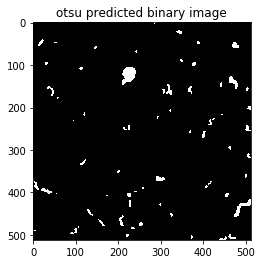

In [11]:
predicted = segment_im(median_filtered, skimage.filters.threshold_otsu)
plt.imshow(predicted, cmap='gray')
plt.title("otsu predicted binary image")

# VALIDATION METRICS

Takeaway - Matthew Correlation Coefficient -https://lettier.github.io/posts/2016-08-05-matthews-correlation-coefficient.html

In [10]:
def get_validation_metrics(groundtruth, predicted):
    """
    Return validation metrics dictionary with accuracy, f1 score, mcc after
    comparing ground truth and predicted image

    :param groundtruth list of ground truth labels with binary values
    :param predicted list of predicted labels with binary values
    :return returns a dictionary with accuracy,f1 score, tp, tn, fp, fn, and mcc as keys
    """
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(groundtruth, predicted).ravel()
    validation_metrics = {}

    validation_metrics["tp"] = tp
    validation_metrics["fp"] = fp
    validation_metrics["fn"] = fn
    validation_metrics["tn"] = tn
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    validation_metrics["accuracy"] = accuracy
    # If all elements are non zero class
    if np.unique(groundtruth).tolist() == np.unique(predicted).tolist() == [1]:
        tn, fp, fn, tp = 0, 0, 0, len(groundtruth)
        f1_score = 1
    # if all elements are zero class i.e background
    elif np.unique(groundtruth).tolist() == np.unique(predicted).tolist() == [0]:
        tn, fp, fn, tp = len(groundtruth), 0, 0, 0
        f1_score = 1
    else:
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(groundtruth, predicted).ravel()
        f1_score = 2 * tp / ((2 * tp) + fp + fn)
    
    validation_metrics["f1_score"] = f1_score
    
    tn = np.float64(tn)
    fp = np.float64(fp)
    fn = np.float64(fn)
    tp = np.float64(tp)
    
    # edge cases
    if (tp == 0 and fp == 0):
        mcc = 0
    elif (tn == 0 and fn == 0):
        mcc = 0
    elif (fp == 0 and fn == 0):
        mcc = 1
    elif (tp == 0 and tn == 0):
        mcc = -1
    elif (tp == 0 and fn == 0):
        mcc = 0
    elif (tn == 0 and fp == 0):
        mcc = 0
    else:
        mcc = ((tp * tn) - (fp * fn)) / (np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
           
    validation_metrics["mcc"] = mcc
    return validation_metrics

In [12]:
groundtruth_list = (groundtruth // 255).flatten().tolist()
predicted_list = (predicted // 255).flatten().tolist()
validation_metrics = get_validation_metrics(groundtruth_list, predicted_list)
print("Validation Metrics comparing Otsu and ground truth")
print(validation_metrics)

Validation Metrics comparing Otsu and ground truth
{'tn': 254564, 'tp': 5595, 'fp': 122, 'fn': 1863, 'mcc': 0.8533910225863214, 'accuracy': 0.9924278259277344, 'f1_score': 0.8493358633776091}


# VALIDATION VISUALIZATION

In [13]:
# Confusion matrix overlay masks where TP, FP, FN, TN columns in the masks are in different colors

def get_confusion_matrix_intersection_mats(groundtruth, predicted):
    """
    Returns a dictionary of 4 boolean numpy arrays containing True at TP, FP, FN, TN.
    """
    confusion_matrix_arrs = {}

    groundtruth_inverse = np.logical_not(groundtruth)
    predicted_inverse = np.logical_not(predicted)

    confusion_matrix_arrs["tp"] = np.logical_and(groundtruth, predicted)
    confusion_matrix_arrs["tn"] = np.logical_and(groundtruth_inverse, predicted_inverse)
    confusion_matrix_arrs["fp"] = np.logical_and(groundtruth_inverse, predicted)
    confusion_matrix_arrs["fn"] = np.logical_and(groundtruth, predicted_inverse)

    return confusion_matrix_arrs


def get_confusion_matrix_overlaid_mask(image, groundtruth, predicted, alpha, colors):
    """
    Returns overlay the 'image' with a color mask where TP, FP, FN, TN are
    each a color given by the 'colors' dictionary
    """
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    masks = get_confusion_matrix_intersection_mats(groundtruth, predicted)
    color_mask = np.zeros_like(image)

    for label, mask in masks.items():
        color = colors[label]
        mask_rgb = np.zeros_like(image)
        mask_rgb[mask != 0] = color
        color_mask += mask_rgb

    return cv2.addWeighted(image, alpha, color_mask, 1 - alpha, 0)

Cyan - TP
Magenta - FP
Yellow - FN
Black - TN


Text(0.5, 1.0, 'confusion matrix overlay mask')

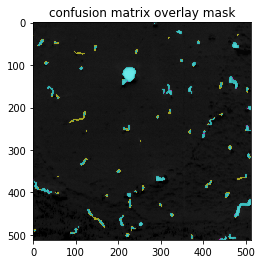

In [14]:
alpha = 0.5
confusion_matrix_colors = {
   "tp": (0, 255, 255),  #cyan
   "fp": (255, 0, 255),  #magenta
   "fn": (255, 255, 0),  #yellow
   "tn": (0, 0, 0)     #black
   }

validation_mask = get_confusion_matrix_overlaid_mask(grayscale, groundtruth, predicted, alpha, confusion_matrix_colors)
print("Cyan - TP")
print("Magenta - FP")
print("Yellow - FN")
print("Black - TN")

plt.imshow(validation_mask)
plt.title("confusion matrix overlay mask")

In [ ]:
def test_exp1():
    assert 1 == 0

test_exp1()

In [ ]:
def test_exp2():
    assert 1 == 1

test_exp2()